In [14]:
import numpy as np
import matplotlib.pyplot as plt
import csv
from scipy.optimize import minimize

### Generating price signal vector (LUCAS's Given Code)

In [82]:
pv = np.array([])
price = np.array([])
demand = np.array([])

with open('building_data.csv', encoding='utf8') as csvfile:
# with open('../../building_data.csv', encoding='utf8') as csvfile:
    csvreader = csv.reader(csvfile, delimiter=',')
    next(csvreader,None)
    rowcount = 0
    for row in csvreader:
        pv = np.append(pv, 0.001*float(row[3])) # Converting Wh to kWh
        price = np.append(price, float(row[2])) # Cost per kWh
        val = row[5]
        if val in (None,""): #How to treat missing values
            val = 0
        else:
            val = float(val) # kWh
        demand = np.append(demand, val)
        rowcount+=1
        # if rowcount>100:
        #     break

pvsize = 50 #Assumption

netdemand = demand.copy()
for i in range(len(demand)):
    netdemand[i] = demand[i] - pvsize*pv[i]

# Data starts at 5 am on Jan 1
day = 45
netdemand_24 = netdemand[24*day-5:24*day+19]
price_24 = price[24*day-5:24*day+19]
pv_24 = pv[24*day-5:24*day+19]
demand_24 = demand[24*day-5:24*day+19]

# Calculate optimal load scheduling. 90% of load is fixed, 10% is controllable.
def optimise_24h(netdemand_24, price_24):
    currentcost = netdemand_24*price_24
    
    fixed_load = 0.9*netdemand_24
    controllable_load = sum(0.1*netdemand_24)
    # fixed_load = 0*netdemand_24
    # controllable_load = sum(netdemand_24)
    
    def objective(x):
        load = fixed_load + x
        cost = np.multiply(price_24,load)
        # Negative demand means zero cost, not negative cost
        # Adding L1 regularisation to penalise shifting of occupant demand
        lambd = 0.005
        return sum(np.maximum(cost,0)) + lambd*sum(abs(x-0.1*netdemand_24))

    def constraint_sumofx(x):
        return sum(x) - controllable_load
    
    def constraint_x_positive(x):
        return x 

    x0 = np.zeros(24)
    cons = [
        {'type':'eq', 'fun': constraint_sumofx},
        {'type':'ineq', 'fun':constraint_x_positive}
    ]
    sol = minimize(objective, x0, constraints=cons)
    #print(sol)
    return sol

sol = optimise_24h(netdemand_24,price_24)
x = sol['x']
#plt.plot(netdemand_24, color='r')
#plt.plot(x + 0.9*netdemand_24, color='b')
# plt.plot(x,color='b')
#plt.plot(demand_24,color='m')
#plt.plot(price_24*100, color='g')
#plt.plot(pv_24*pvsize,color='y')
#plt.show()

# Signal should be according to what the optimal shifted controllable load is (x)
#signal = x / np.linalg.norm(x)

signal = pv_24*pvsize
#plt.show()

# Pre-Treatment Dataset 1 (BaselineHourlyData)
### Summed over all work groups, then averaged by num of days

In [40]:
total_energy_used = [0.0 for i in range(24)]
with open('BaselineHourlyData.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    curr_wg = ["WORKGROUP-01","WORKGROUP-02","WORKGROUP-03"]
    for row in readCSV:
        if(row[0]=="index"):
            continue
        else:
            if(row[4] in curr_wg):
                curr_hour = int(float(row[3]))
                net_pwr_used = row[8]
                if(net_pwr_used != ""):
                    net_pwr_used = float(net_pwr_used)
                    total_energy_used[curr_hour] = total_energy_used[curr_hour] + net_pwr_used
                #otherwise net_pwr = 0

avg_energy_used = [p / 62.0 for p in total_energy_used]
avg_energy_used = avg_energy_used[9:] + avg_energy_used[:9]
avg_energy_used = np.array(avg_energy_used)

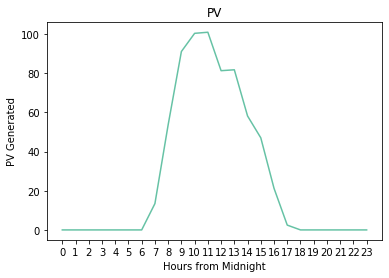

In [41]:
plt.plot(signal,'#66c2a5')
plt.xlabel("Hours from Midnight")
plt.xticks([i for i in range(0,24)])
plt.ylabel("PV Generated")
plt.title("PV")
plt.show()

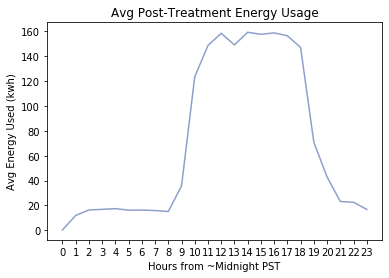

In [42]:
plt.plot(avg_energy_used,'#8da0cb')
plt.xlabel("Hours from ~Midnight PST")
plt.xticks([i for i in range(0,24)])
plt.ylabel("Avg Energy Used (kwh)")
plt.title("Avg Post-Treatment Energy Usage")
plt.show()

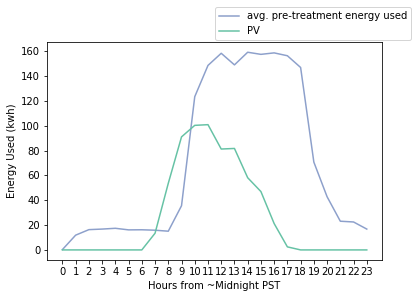

In [43]:
plt.plot(avg_energy_used,label="avg. pre-treatment energy used",color='#8da0cb')
plt.plot(signal,label='PV',color='#66c2a5')
plt.xlabel("Hours from ~Midnight PST")
plt.ylabel("Energy Used (kwh)")
plt.xticks([i for i in range(0,24)])
plt.legend(loc=(0.5,1.01))

# During Treatment Data
#### Using same subset as before
#### In our post-treatment data, we don't have all of 10/14

In [48]:
total_energy_used = [0.0 for i in range(24)]
with open('HourlyDataFinal.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    curr_wg = ["WORKGROUP-01","WORKGROUP-02","WORKGROUP-03"]
    prev_hour_usage = 0.0
    for row in readCSV:  
        if(row[2] == "Date"):
            continue
        else:
            if(row[5] in curr_wg):
                curr_hour = int(float(row[4]))
                net_pwr_used = row[9]
                if(net_pwr_used != ""):
                    net_pwr_used = float(net_pwr_used)
                    total_energy_used[curr_hour] = total_energy_used[curr_hour] + net_pwr_used
total_energy_used = total_energy_used[10:] + total_energy_used[:10]
avg_energy_used_post = np.array([p / 77.0 for p in total_energy_used])

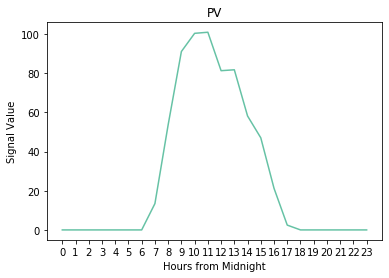

In [49]:
plt.plot(signal,label='PV Generated',color='#66c2a5')
plt.xlabel("Hours from Midnight")
plt.xticks([i for i in range(0,24)])
plt.ylabel("Signal Value")
plt.title("PV")
plt.show()

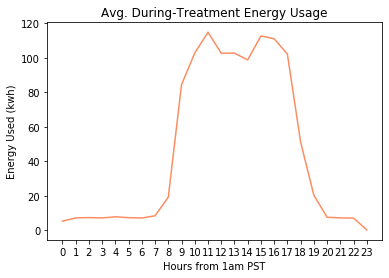

In [50]:
plt.plot(avg_energy_used_post,label="avg. during-treatment energy used",color='#fc8d62')
plt.xlabel("Hours from 1am PST")
plt.xticks([i for i in range(0,24)])
plt.ylabel("Energy Used (kwh)")
plt.title("Avg. During-Treatment Energy Usage")
plt.show()

## Combining Signal and Post-Treatment Graph (*Scale factor tbd)

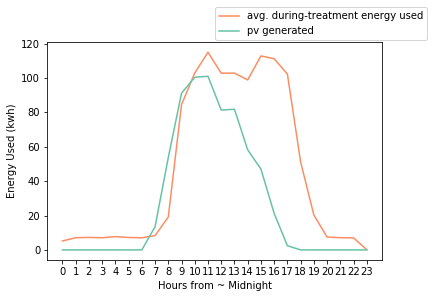

In [53]:
plt.plot(avg_energy_used_post,label="avg. during-treatment energy used",color='#fc8d62')
plt.plot(signal,label='pv generated',color='#66c2a5')
plt.xlabel("Hours from ~ Midnight")
plt.ylabel("Energy Used (kwh)")
plt.xticks([i for i in range(0,24)])
plt.legend(loc=(0.5,1.01))

# Power Analysis:
## Combining Pre, Post, and Signal
#### Once again for the aforementioned subset

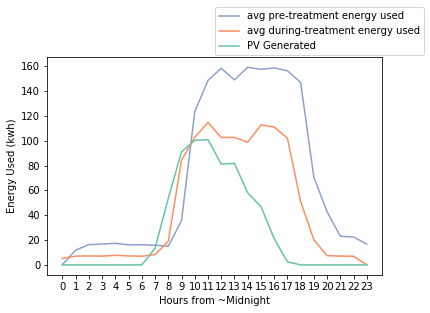

In [55]:
plt.plot(avg_energy_used,label="avg pre-treatment energy used",color='#8da0cb')
plt.plot(avg_energy_used_post,label="avg during-treatment energy used",color='#fc8d62')
plt.plot(signal,label='PV Generated',color='#66c2a5')
plt.xlabel("Hours from ~Midnight")
plt.ylabel("Energy Used (kwh)")
plt.xticks([i for i in range(0,24)])
plt.legend(loc=(0.5,1.01))

# Analyzing one-month
## Energy usage at the daily level

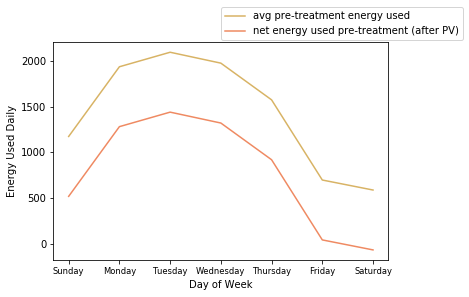

In [109]:
#pre-treatment
total_energy_daily = [0.0 for i in range(7)]
days_seen = [0 for i in range(7)]
days = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":0}
with open('BaselineHourlyData.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    curr_wg = ["WORKGROUP-01","WORKGROUP-02","WORKGROUP-03"]
    month = 6
    for row in readCSV:
        if(row[0]=="index"):
            continue
        else:
            if(row[4] in curr_wg and int(row[1][6]) == month):
                curr_day = days[row[2]]
                net_pwr_used = row[8]
                if(net_pwr_used != ""):
                    net_pwr_used = float(net_pwr_used)
                    total_energy_daily[curr_day] = total_energy_daily[curr_day] + net_pwr_used
                #otherwise net_pwr = 0
tot_e = total_energy_daily
avg_energy_daily = [tot_e[i] / 4 for i in range(0,5)] + [tot_e[i] / 5 for i in range(5,7)]
days = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
pv_daily = sum(signal)
net_nonPV_daily = [avg_energy_daily[i]-pv_daily for i in range(0,7)]
plt.plot(avg_energy_daily,label="avg pre-treatment energy used",color='#d8b365')
plt.plot(net_nonPV_daily,label="net energy used pre-treatment (after PV)",color="#ef8a62")
plt.xlabel("Day of Week")
plt.ylabel("Energy Used Daily")
plt.xticks(range(len(net_nonPV_daily)),days, size = "small")
plt.legend(loc=(0.5,1.01))

[1168.862505, 971.3975000000006, 857.2899974999997, 1018.0020000000006, 1031.1400001999991, 669.0740940000001, 365.61273250000033]
651.57835


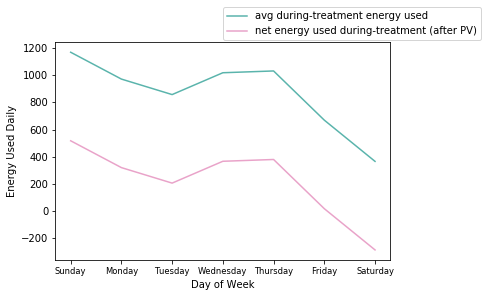

In [110]:
#during-treatment
total_energy_daily = [0.0 for i in range(7)]
days = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":0}
with open('HourlyDataFinal.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    curr_wg = ["WORKGROUP-01","WORKGROUP-02","WORKGROUP-03"]
    month = 8
    for row in readCSV:  
        if(row[2] == "Date"):
            continue
        else:
            if(row[5] in curr_wg and int(row[2][6]) == month):
                curr_day = days[(row[3])]
                net_pwr_used = row[9]
                if(net_pwr_used != ""):
                    net_pwr_used = float(net_pwr_used)
                    total_energy_daily[curr_day] = total_energy_daily[curr_day] + net_pwr_used
tot_e_post = total_energy_daily
post_avg_energy_daily = [tot_e_post[i] / 4 for i in range(0,3)] + [tot_e_post[i] / 5 for i in range(3,6)] + [tot_e_post[6]/4]
print(post_avg_energy_daily)
days = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]
pv_daily = sum(signal)
print(pv_daily)
post_net_nonPV_daily = [post_avg_energy_daily[i]-pv_daily for i in range(0,7)]
plt.plot(post_avg_energy_daily,label="avg during-treatment energy used",color='#5ab4ac')
plt.plot(post_net_nonPV_daily,label="net energy used during-treatment (after PV)",color="#e9a3c9")
plt.xlabel("Day of Week")
plt.ylabel("Energy Used Daily")
plt.xticks(range(len(net_nonPV_daily)),days, size = "small")
plt.legend(loc=(0.5,1.01))

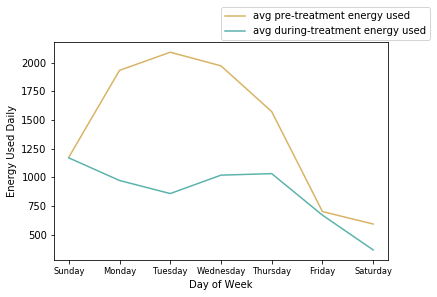

In [111]:
plt.plot(avg_energy_daily,label="avg pre-treatment energy used",color='#d8b365')
plt.plot(post_avg_energy_daily,label="avg during-treatment energy used",color='#5ab4ac')
plt.xlabel("Day of Week")
plt.ylabel("Energy Used Daily")
plt.xticks(range(len(net_nonPV_daily)),days, size = "small")
plt.legend(loc=(0.5,1.01))

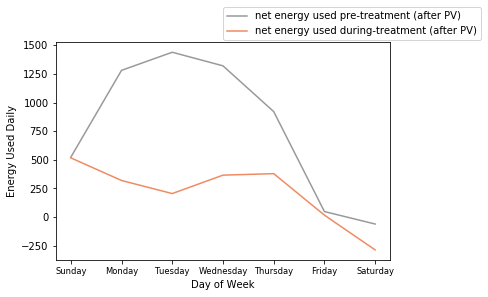

In [112]:
plt.plot(net_nonPV_daily,label="net energy used pre-treatment (after PV)",color="#999999")
plt.plot(post_net_nonPV_daily,label="net energy used during-treatment (after PV)",color="#ef8a62")
plt.xlabel("Day of Week")
plt.ylabel("Energy Used Daily")
plt.xticks(range(len(net_nonPV_daily)),days, size = "small")
plt.legend(loc=(0.5,1.01))

['Time Around Treatment', 'Treatment Number', 'Date', 'Day of Week', 'Hour', 'WorkGroup', 'Desk', 'TotalEnergy', 'Desk_Indicator', 'NetEnergy', 'Name', 'Deviation', 'Treatment0', 'Treatment1', 'Treatment2', 'Weekend_Indicator', 'Treatment_Indicator', 'cTAT', 'TreatmentArray', 'LoginCount', 'DurationCount']


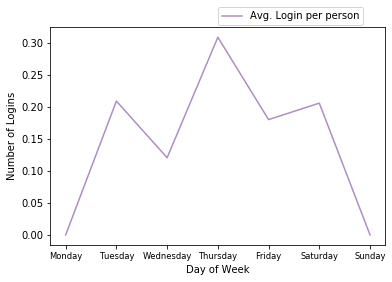

In [125]:
### Look at log-in participation
#during-treatment
total_login_daily = [0.0 for i in range(7)]
days = {"Monday":1,"Tuesday":2,"Wednesday":3,"Thursday":4,"Friday":5,"Saturday":6,"Sunday":0}
with open('HourlyDataFinal.csv') as csvfile:
    readCSV = csv.reader(csvfile, delimiter=',')
    end_hr = 23
    month = 8
    for row in readCSV:  
        if(row[2] == "Date"):
            print(row)
            continue
        else:
            if(int(row[2][6]) == month):
                curr_day = days[(row[3])]
                curr_hr = int(float(row[4]))
                if(curr_hr == end_hr ):
                    login = row[-2]
                    if(login != ""):
                        total_login_daily[curr_day] = total_login_daily[curr_day] + float(login)
avg_login_daily = [total_login_daily[i]/4 for i in range(0,3)] + [total_login_daily[i]/5 for i in range(3,6)] + [total_login_daily[6]/4]
avg_login_daily = [l / 31 for l in avg_login_daily]
plt.plot(avg_login_daily,label="Avg. Login per person",color="#af8dc3")
plt.xlabel("Day of Week")
plt.ylabel("Number of Logins")
plt.xticks(range(len(net_nonPV_daily)),days, size = "small")
plt.legend(loc=(0.5,1.01))